In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,KFold, cross_val_score,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from time import time

## Data Import & Exploration

In [2]:
# Switching to the source directory

project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
project_root
print(project_root)

C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_estimator


In [3]:
# Define datasource path

data_source = 'data'
file_name = 'premiums'
file_extension = 'xlsx'

datasource_path = fr'{project_root}\{data_source}\{file_name}.{file_extension}'
datasource_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator\\data\\premiums.xlsx'

In [4]:
# Reading the data

df = pd.read_excel(datasource_path,sheet_name='Sheet1')

In [5]:
# Displaying the data

df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [6]:
df.shape

(50000, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    50000 non-null  int64 
 1   Gender                 50000 non-null  object
 2   Region                 50000 non-null  object
 3   Marital_status         50000 non-null  object
 4   Number Of Dependants   50000 non-null  int64 
 5   BMI_Category           50000 non-null  object
 6   Smoking_Status         49989 non-null  object
 7   Employment_Status      49998 non-null  object
 8   Income_Level           49987 non-null  object
 9   Income_Lakhs           50000 non-null  int64 
 10  Medical History        50000 non-null  object
 11  Insurance_Plan         50000 non-null  object
 12  Annual_Premium_Amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


## Data Cleaning

The following steps were performed during data cleaning:

- Handling missing values
- Removing duplicated rows
- Formatting numeric and categorical values
- Treating outliers to improve data quality

### Column Formatter

In [8]:
# Renaming the columns with proper formatter
# Eg: Number Of Dependants -> number_of_dependants

df.columns = df.columns.str.replace(' ','_').str.lower()

In [9]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Handling Missing Values

In [10]:
# Finding the columns with NA values

df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [11]:
# Dropping the Rows where it has NA value

# Before Dropping
df[df['smoking_status'].isna()].head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
177,26,Female,Southwest,Married,3,Underweight,NaN,Salaried,> 40L,69,Diabetes,Gold,22605
15648,47,Male,Southwest,Married,4,Normal,NaN,Freelancer,25L - 40L,32,Diabetes,Gold,26100
16324,45,Male,Northwest,Married,4,Overweight,NaN,Salaried,10L - 25L,16,High blood pressure & Heart disease,Silver,21881
16941,34,Male,Southwest,Married,5,Normal,NaN,Self-Employed,25L - 40L,35,High blood pressure & Heart disease,Gold,25865
16975,23,Male,Southwest,Unmarried,0,Normal,NaN,Freelancer,<10L,3,No Disease,Bronze,6001


Since the count is low, the rows containing at least one missing value were dropped.

In [12]:
# Dropping
df.dropna(how='any',inplace = True)

In [13]:
# After Dropping
df[df['smoking_status'].isna()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


In [14]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [15]:
df.reset_index(inplace=True,drop=True)

### Handling Duplicated Rows

In [16]:
# Duplicated rows

df[df.duplicated()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


Although there are no duplicated rows, they are being dropped as a precautionary measure.

In [17]:
# Dropping the duplicated rows

df.drop_duplicates(inplace=True)

### Fomatting Values - Numeric Columns

In [18]:
df.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [19]:
# Selecting only the columns with numerical values

numeric_columns = df.select_dtypes(include=['int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [20]:
# Printing the unique values of each numeric columns to identify the values with improper formats

for col in numeric_columns:
    print(f'{col}:\n',df[col].unique())
    print('*'*100)

age:
 [ 26  29  49  30  18  56  33  43  59  22  21  46  68  60  27  25  36  20
  28  32  19  55  35  52  40  23  50  41  67  37  24  34  54  42  45  44
  57  38  31  58  48  51 224  47  39  53  66  64  65  62  61  70  72  69
  71 124  63 136 203 356]
****************************************************************************************************
number_of_dependants:
 [ 0  2  3  4  1  5 -3 -1]
****************************************************************************************************
income_lakhs:
 [  6  20  77  99  14   4  46  21   3  97   1  27  15  18   7  37  30  13
   8  83  19  29   5  70  11  33  23  40  84  22   9  71  59  38  35  28
  39  57  25  12  36  92   2  24  16  34  93  78  26  49  68  52  62  31
  90  50  32  10  88  54  86  41  95  64  85  81  79  56  80  17  98  89
  82 100  44  66  53  75  94  69  58  74  65  91  42  61  87  96  51  67
  43  73  63  55  48  45  47  72  60 560  76 440 630 900 930 580 700 790
 770 680]
***********************************

The negative values in `number_of_dependents` should be handled by converting them to their absolute values.

In [21]:
# Before formatting

df['number_of_dependants'].unique()

array([ 0,  2,  3,  4,  1,  5, -3, -1])

In [22]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [23]:
# After formatting

df['number_of_dependants'].unique()

array([0, 2, 3, 4, 1, 5])

### Fomatting Values - Categorical Columns

In [24]:
# Selecting only the columns with categorical values

cat_columns = df.select_dtypes(include=['object']).columns
cat_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [25]:
# Printing the unique values of each categorical columns to identify the values with improper formats

for col in cat_columns:
    print(f'{col}:\n',list(df[col].unique()))
    print('*'*100)

gender:
 ['Male', 'Female']
****************************************************************************************************
region:
 ['Northwest', 'Southeast', 'Northeast', 'Southwest']
****************************************************************************************************
marital_status:
 ['Unmarried', 'Married']
****************************************************************************************************
bmi_category:
 ['Normal', 'Obesity', 'Overweight', 'Underweight']
****************************************************************************************************
smoking_status:
 ['No Smoking', 'Regular', 'Occasional', 'Smoking=0', 'Does Not Smoke', 'Not Smoking']
****************************************************************************************************
employment_status:
 ['Salaried', 'Self-Employed', 'Freelancer']
****************************************************************************************************
income_level:
 ['<10L', '10L 

As indicated by the above result, the `smoking_status` column contains multiple values with the same meaning; therefore, this column will be formatted.

In [26]:
# Before formatting

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional', 'Smoking=0',
       'Does Not Smoke', 'Not Smoking'], dtype=object)

In [27]:
# Replacing values with desired formats

df['smoking_status'] = df['smoking_status'].replace(
    {
       'Smoking=0' : 'No Smoking',
        'Does Not Smoke' : 'No Smoking',
        'Not Smoking' : 'No Smoking',
    }
)

In [28]:
# After formatting

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Outlier Treatment

In [29]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


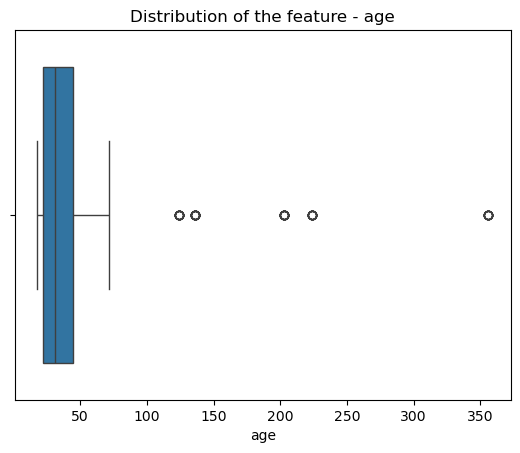

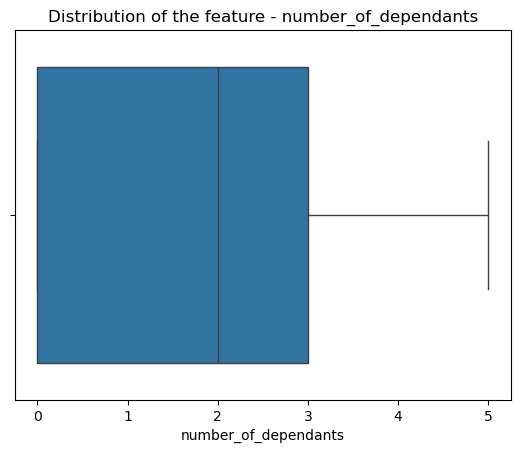

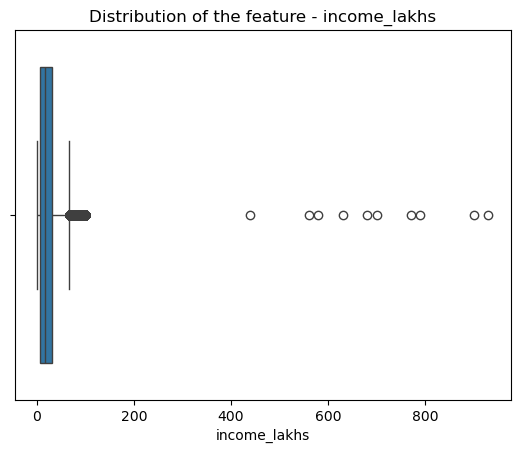

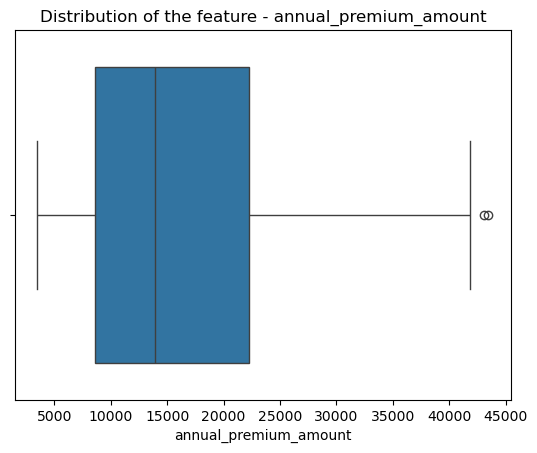

In [30]:
# Plotting box plot for each numerical columns to detect outliers

for col in numeric_columns:
    sns.boxplot(data=df,x=col)
    plt.title(f'Distribution of the feature - {col}')
    plt.show()

As observed above, outliers are present in the `age` and `income_lakhs` columns. This is also illustrated by the box plot shown above.

#### Age

In [31]:
# Before
df['age'].unique()

array([ 26,  29,  49,  30,  18,  56,  33,  43,  59,  22,  21,  46,  68,
        60,  27,  25,  36,  20,  28,  32,  19,  55,  35,  52,  40,  23,
        50,  41,  67,  37,  24,  34,  54,  42,  45,  44,  57,  38,  31,
        58,  48,  51, 224,  47,  39,  53,  66,  64,  65,  62,  61,  70,
        72,  69,  71, 124,  63, 136, 203, 356])

In [32]:
# Selecting only the rows where age <= 100. Because age > 100 is outlier

df1 = df[df['age'] <= 100]
df1.reset_index(inplace=True,drop=True)

In [33]:
# After
df1['age'].unique()

array([26, 29, 49, 30, 18, 56, 33, 43, 59, 22, 21, 46, 68, 60, 27, 25, 36,
       20, 28, 32, 19, 55, 35, 52, 40, 23, 50, 41, 67, 37, 24, 34, 54, 42,
       45, 44, 57, 38, 31, 58, 48, 51, 47, 39, 53, 66, 64, 65, 62, 61, 70,
       72, 69, 71, 63])

#### Income

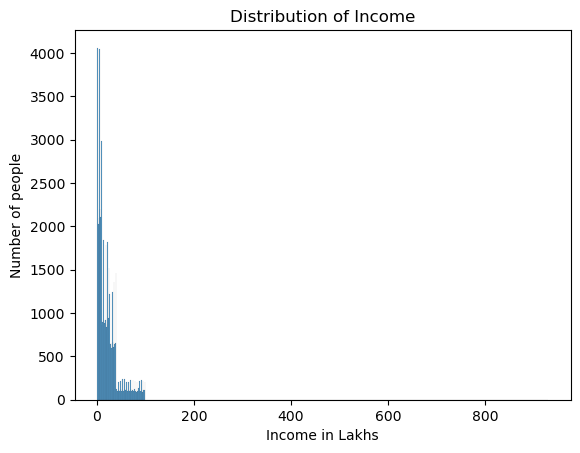

In [34]:
# Distribution of Income using Histogram

sns.histplot(data=df1,x='income_lakhs')
plt.title('Distribution of Income')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

In [35]:
# Determining Lower Salary Boundary and Upper Salary Boundary using IQR Method

# Quartile 1 and Quartile 3

q1 = np.percentile(df1['income_lakhs'],25)
q3 = np.percentile(df1['income_lakhs'],75)
print(f'Q1 -> {q1}\nQ3 -> {q3}')

# Inter Qurartile Range

iqr = q3-q1
print('IQR ->',iqr)

# Lower and Upper boundary using IQR

lower_boundary = q1 - (iqr * 1.5)
upper_boundary = q3 + (iqr * 1.5)
print(f'Lower Boundary -> {lower_boundary}\nUpper Boundary -> {upper_boundary}')

Q1 -> 7.0
Q3 -> 31.0
IQR -> 24.0
Lower Boundary -> -29.0
Upper Boundary -> 67.0


NOTE:

The current upper boundary is too low. Therefore, consultation with the business team will be conducted to determine the optimal upper boundary for identifying outliers in the income_lakhs column.

It has been decided that the upper boundary will be set at 1 crore (i.e., 100 lakhs). Any values exceeding this threshold will be considered outliers.

In [36]:
# Selecting only the rows where income <= 100 lakhs. Because income > 100 lakhs is outlier

income_threshold = 100
df2 = df1[df1['income_lakhs'] <= income_threshold]

In [37]:
df2.reset_index(drop=True,inplace=True)

In [38]:
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49903,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111
49904,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076
49905,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564
49906,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,9490


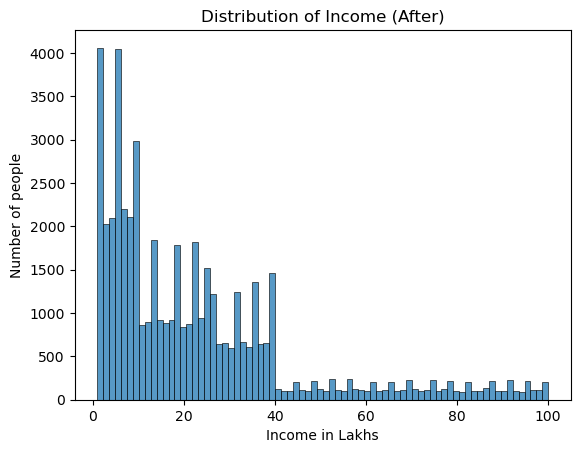

In [39]:
# After Treating outliers in 'income_lakhs' columns

sns.histplot(data=df2,x='income_lakhs')
plt.title('Distribution of Income (After)')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

## EDA

Exploratory Data Analysis (EDA) is performed as follows:

- Univariate analysis on numeric columns
- Univariate analysis on categorical columns
- Bivariate analysis on numeric columns
- Bivariate analysis on categorical columns

### Univariate Analysis - Numeric Columns

The distribution of numerical columns will be plotted using histograms.

In [40]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

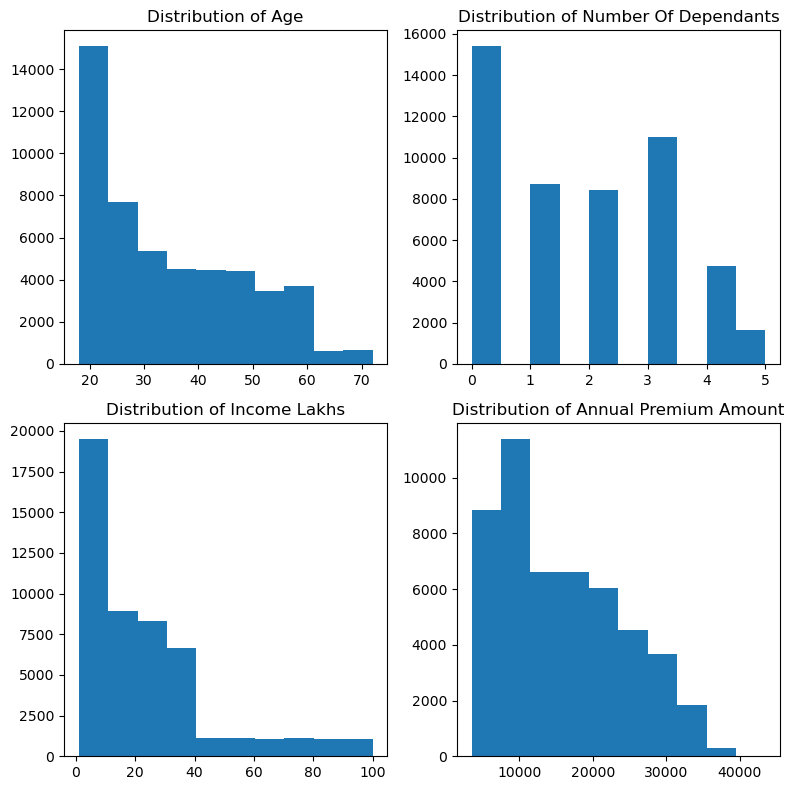

In [41]:
# Plotting Distribution for all numerical columns

fig , ax = plt.subplots(2,2,figsize=(8,8))

# Iterator initiation to retrive one value at a time
it = iter(numeric_columns)

for i in range(2):
    for j in range(2):
        # To retrive one value at a time
        col = next(it)
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')
        ax[i,j].hist(x=df2[col])
        ax[i,j].set_title(f'Distribution of {x_ax}')
        
# To adjust subplot parameters to give specified padding and prevent overlap of labels
plt.tight_layout()
plt.show()

### Univariate Analysis - Categorical Columns

The distribution of categorical columns will be plotted using barcharts.

In [42]:
df2[cat_columns]

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northwest,Unmarried,Normal,No Smoking,Salaried,<10L,Diabetes,Bronze
1,Female,Southeast,Married,Obesity,Regular,Salaried,<10L,Diabetes,Bronze
2,Female,Northeast,Married,Normal,No Smoking,Self-Employed,10L - 25L,High blood pressure,Silver
3,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,No Disease,Gold
4,Male,Northeast,Unmarried,Overweight,Regular,Self-Employed,> 40L,High blood pressure,Silver
...,...,...,...,...,...,...,...,...,...
49903,Female,Northwest,Unmarried,Underweight,No Smoking,Self-Employed,25L - 40L,No Disease,Bronze
49904,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,Thyroid,Gold
49905,Male,Northwest,Unmarried,Normal,Regular,Freelancer,25L - 40L,No Disease,Bronze
49906,Male,Northwest,Unmarried,Normal,No Smoking,Salaried,10L - 25L,No Disease,Bronze


In previous runs, the x-axis labels for the `medical_history` column were misaligned in the plots. To resolve this issue, the values will be mapped using the dictionary *ds_dict* as shown below.

In [43]:
ds_dict = {'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

ds_dict

{'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

In [44]:
# Showing how mapping works

print('Without Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index))
print('\n','*'*100,'\n')
print('With Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index.map(ds_dict)))

Without Mapping:
['No Disease', 'Diabetes', 'High blood pressure', 'Thyroid', 'Heart disease', 'Diabetes & High blood pressure', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Diabetes & Heart disease']

 **************************************************************************************************** 

With Mapping:
['NO DISEASE', 'DB', 'HBP', 'THY', 'HD', 'DB & HBP', 'HBP & HD', 'DB & THY', 'DB & HD']


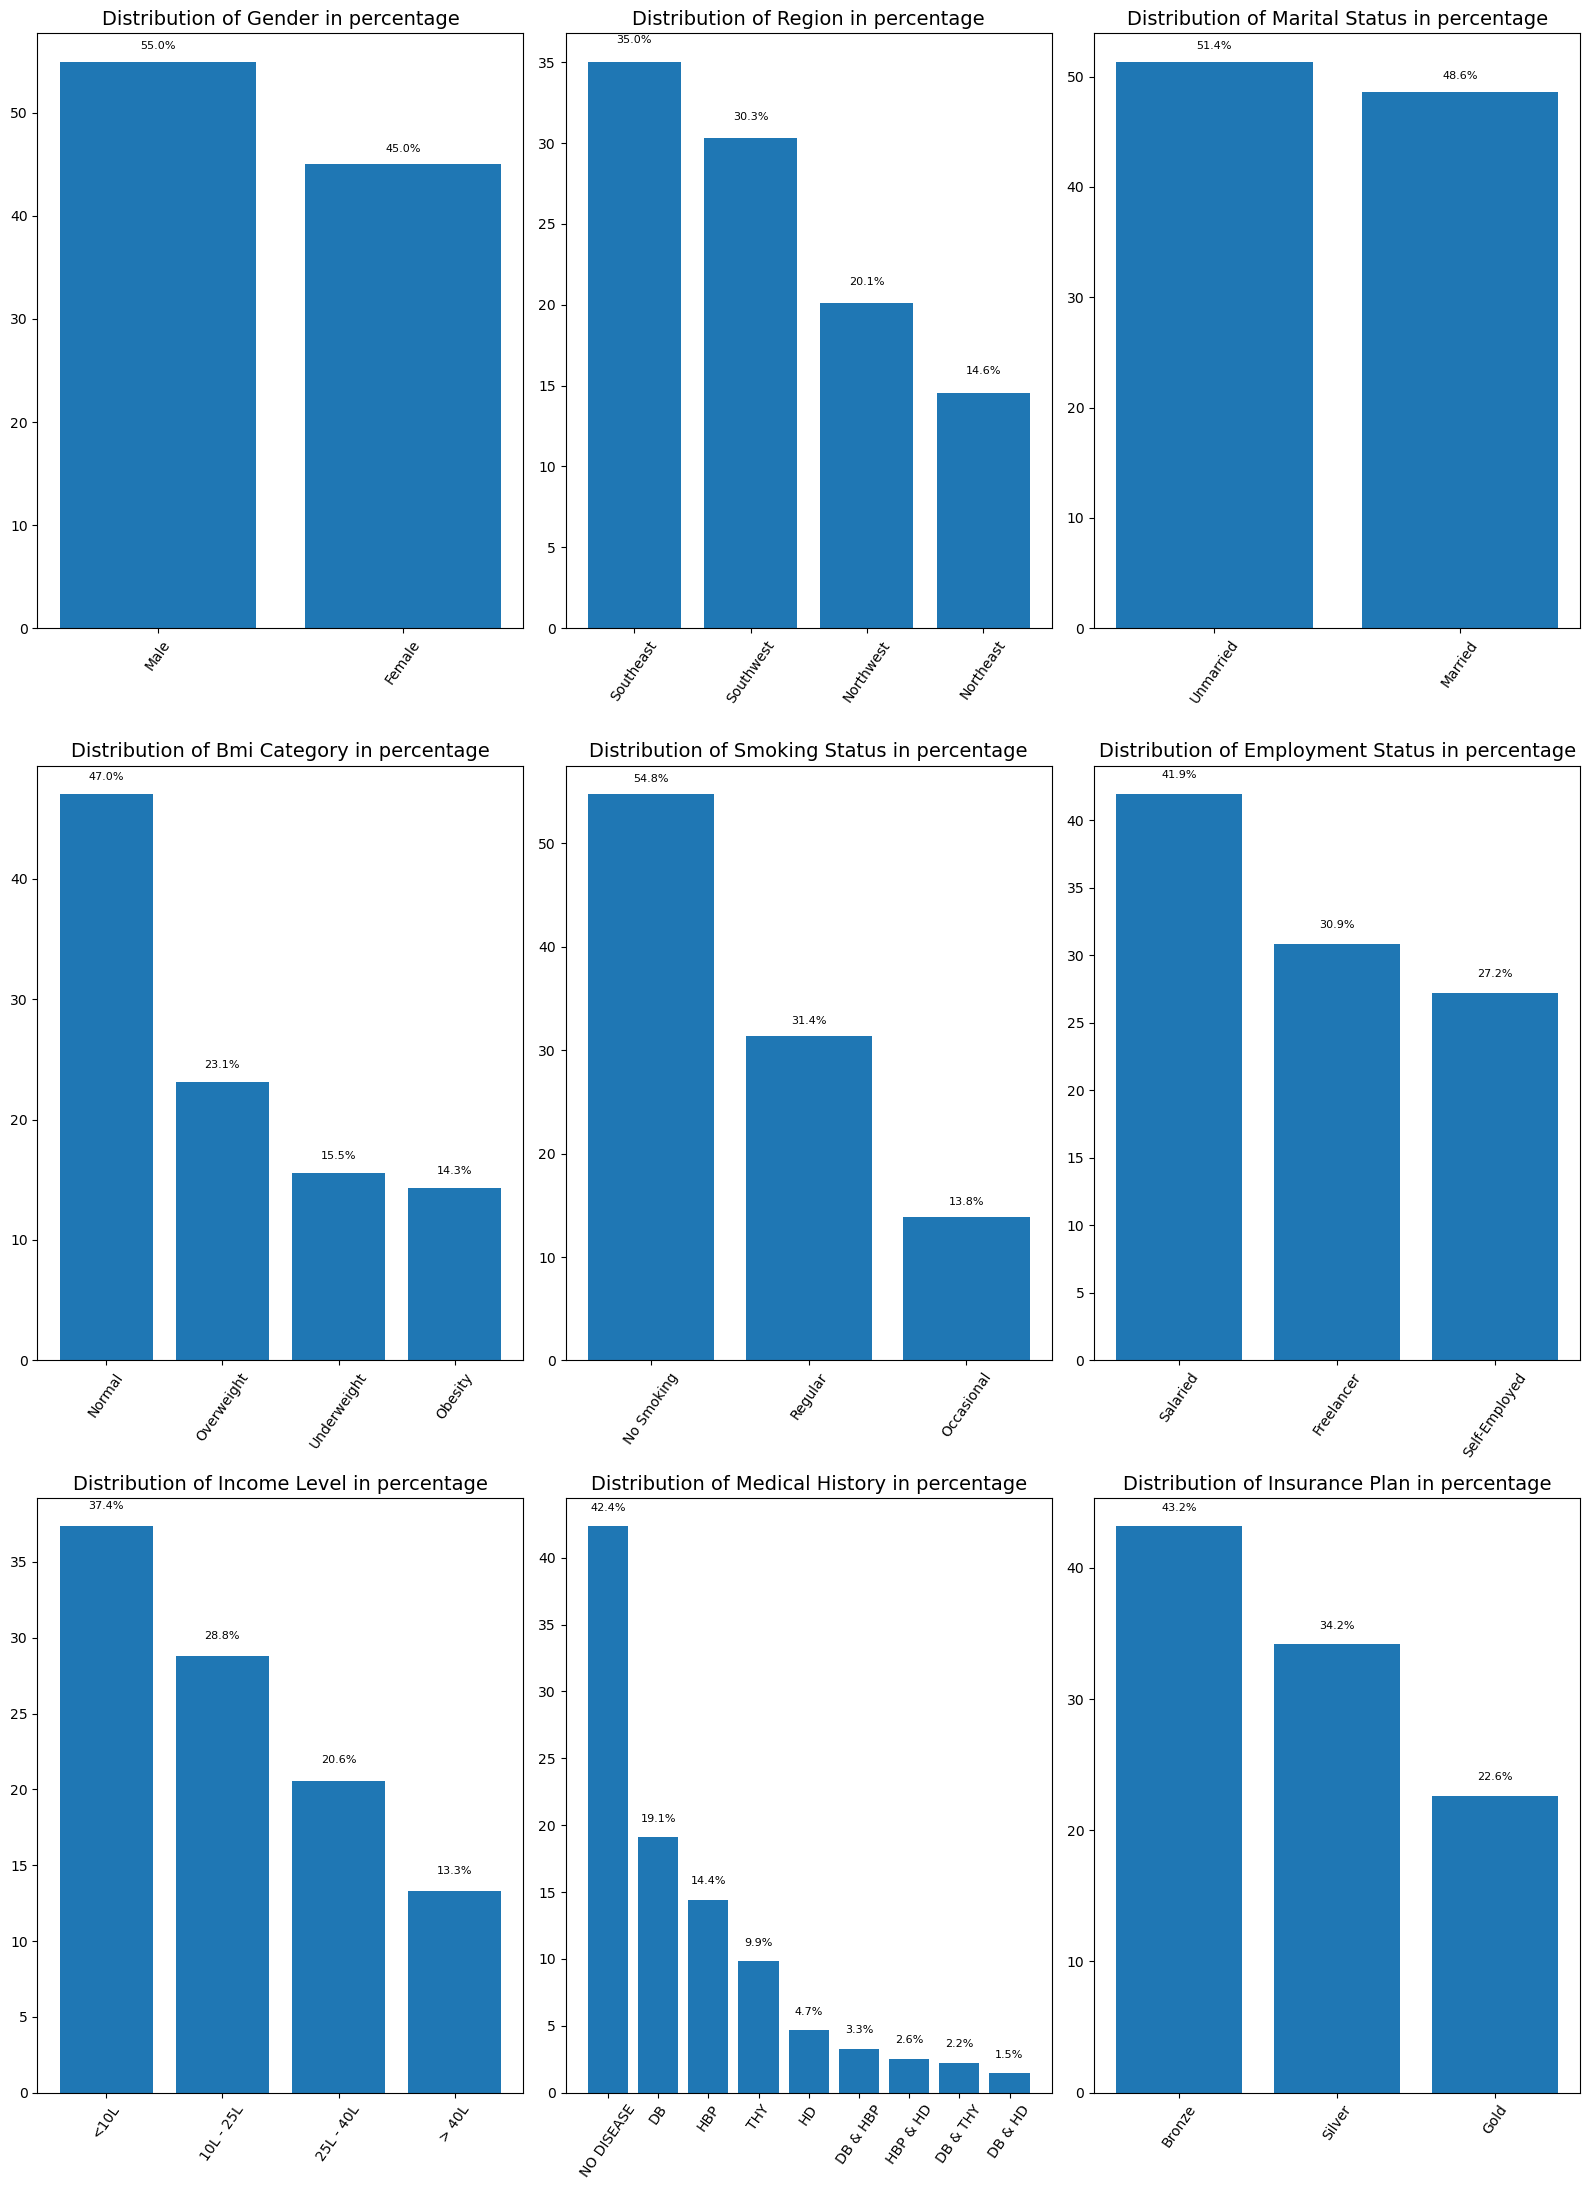

In [45]:
# Plotting Distribution for all categorical columns

fig, ax = plt.subplots(3,3,figsize=(16,22))

# Iterator initiation to retrive one value at a time
it = iter(cat_columns)

for i in range(3):
    for j in range(3):
        # To retrive one value at a time
        col = next(it)
        
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')

        # Map the 'medical_history' column using ds_dict to ensure consistent and clean labels for plotting
        
        if col == 'medical_history':
            x_val = df2[col].value_counts(normalize=True).index.map(ds_dict)
        else:
            x_val = df2[col].value_counts(normalize=True).index
            
        h_val = df2[col].value_counts(normalize=True).values * 100
        ax[i,j].bar(x=x_val,height=h_val)
        ax[i,j].set_title(f'Distribution of {x_ax} in percentage',fontsize=14)
        ax[i,j].tick_params(axis='x', rotation=55)
        
        # Annotate each bar with its corresponding percentage value for better interpretability
        for idx, val in enumerate(h_val):
            ax[i,j].text(idx, val + 1, f'{round(val,1)}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Bivariate Analysis - Numeric Columns

The relationship between each numerical column (excluding the `annual_premium_amount` column itself) and the `annual_premium_amount` column will be plotted to analyze potential correlations.

In [46]:
df2[numeric_columns]

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,26,0,6,9053
1,29,2,6,16339
2,49,2,20,18164
3,30,3,77,20303
4,18,0,99,13365
...,...,...,...,...
49903,24,0,35,9111
49904,47,2,82,27076
49905,21,0,32,8564
49906,18,2,20,9490


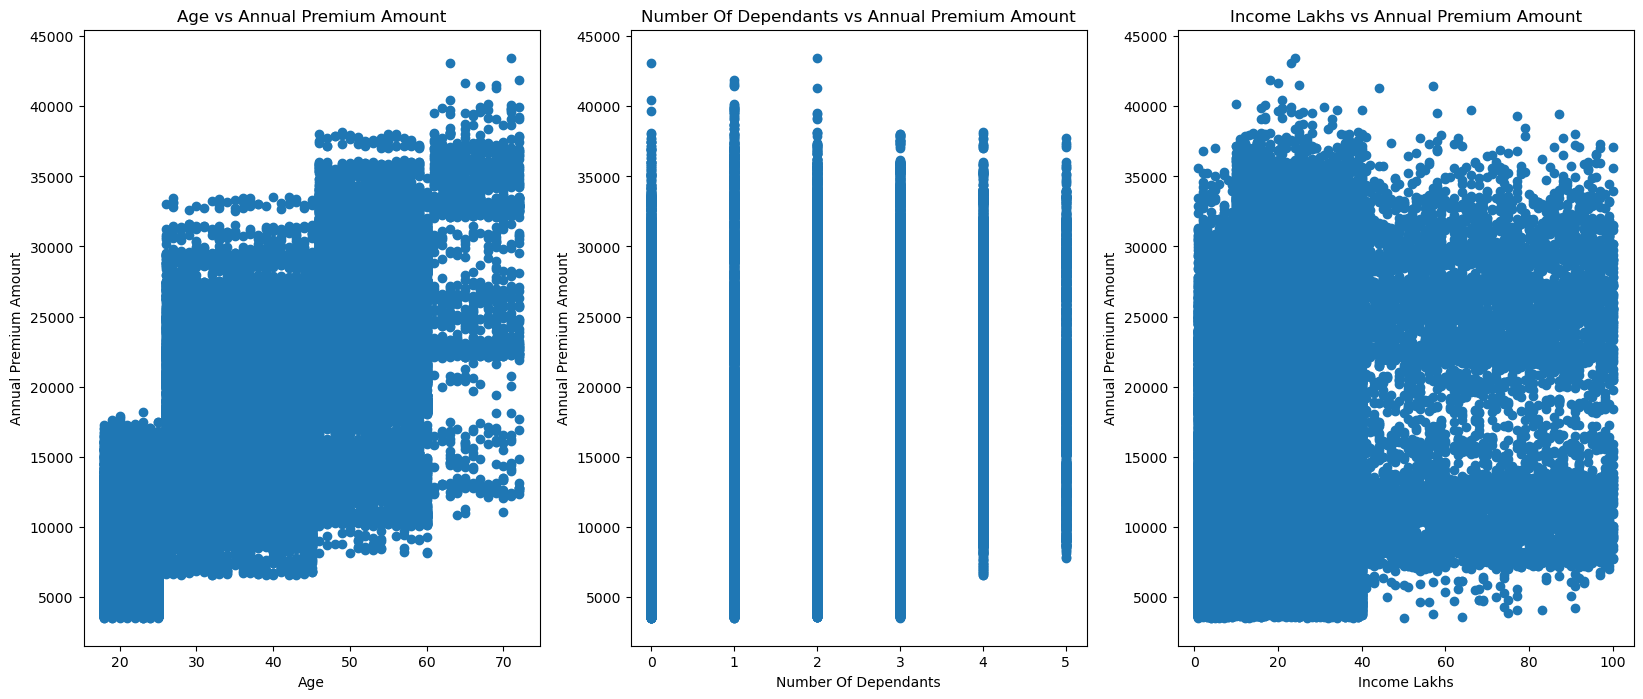

In [47]:
# Plotting the scatter plots

fig, ax = plt.subplots(1,3,figsize=(20,8))

for i in range(3):
    col = numeric_columns[i]
    
    # Format column names for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')
    y_ax = 'annual_premium_amount'.title().replace('_',' ')
    
    ax[i].scatter(x=df2[col],y=df2['annual_premium_amount'])
    ax[i].set_title(f'{x_ax} vs {y_ax}')
    ax[i].set_xlabel(x_ax)
    ax[i].set_ylabel(y_ax)

### Bivariate Analysis - Categorical

The relationship between the categorical columns `income_level` and `insurance_plan` will be explored using multiple approaches:

* Cross-tabulation
* Grouped Bar Chart
* Stacked Bar Chart
* Heatmap
  

In [48]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


#### Cross-tabulation

The frequency distribution between `income_level` and `insurance_plan` will be examined using a cross-tabulation, which will display the number of individuals in each combination of income level and insurance plan.

In [49]:
ct = pd.crosstab(df['income_level'],df['insurance_plan'])
ct

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5314,3886,5189
25L - 40L,3686,2844,3753
<10L,12239,931,5495
> 40L,330,3662,2647


In [50]:
# Reorder rows and columns
row_order = ['<10L', '10L - 25L', '25L - 40L', '> 40L']
col_order = ['Bronze', 'Silver', 'Gold']

In [51]:
# Reordered CT

ct = ct.loc[row_order, col_order]
ct

insurance_plan,Bronze,Silver,Gold
income_level,,,
<10L,12239,5495,931
10L - 25L,5314,5189,3886
25L - 40L,3686,3753,2844
> 40L,330,2647,3662


#### Grouped Bar Chart

The count of each `insurance_plan` across different `income_level` categories will be visualized using grouped bar charts, where each income level will have side-by-side bars representing the different insurance plans for easy comparison.

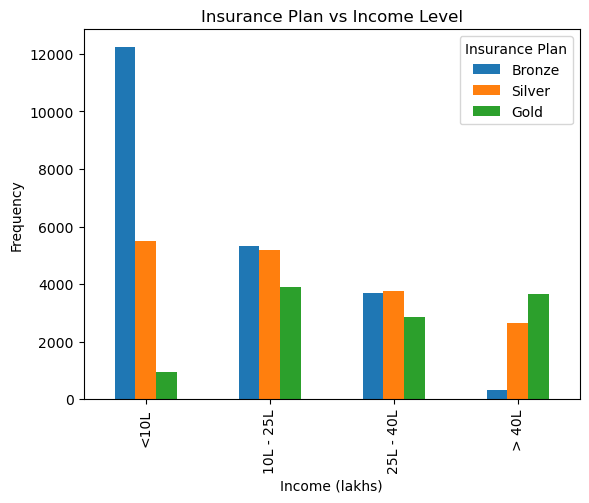

In [52]:
ct.plot(kind='bar')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Stacked Bar Chart

The distribution of `insurance_plan` within each `income_level` will be represented in a stacked bar chart format, helping to understand the proportion of each plan type within the income categories.

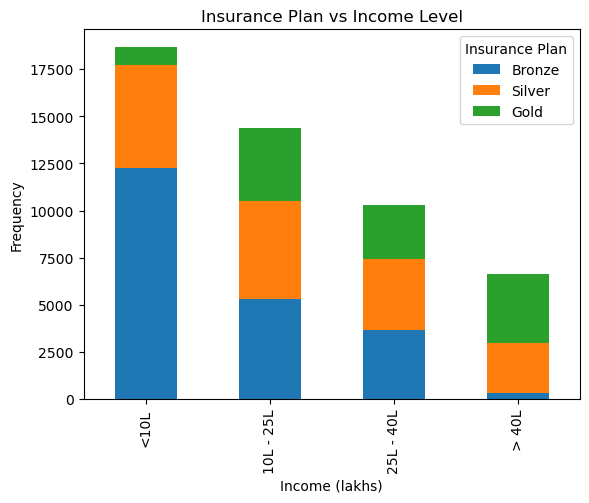

In [53]:
ct.plot(kind='bar',stacked=True)
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Heatmap

The intensity of the relationship between `insurance_plan` and `income_level` will be visualized using a heatmap, where the cells are color-coded based on frequency to highlight patterns and concentrations in the data.

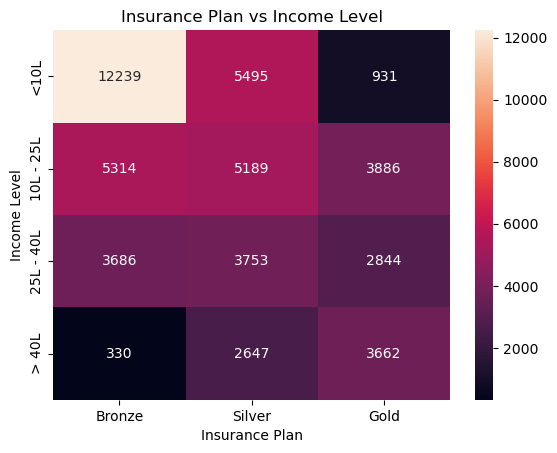

In [54]:
sns.heatmap(ct,annot=True,fmt='0')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.show()

## Feature Engineering

The following feature engineering steps were performed:

- Created new features as required
- Transformed features, including encoding categorical variables
- Selected important features using statistical methods such as Variance Inflation Factor (VIF) and correlation analysis

### Feature Creation - 'total_risk_score'

In this we created a new feature `total_risk_score` from `medical_history` column

In [55]:
# Extract all distinct medical conditions listed in the dataset

df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

The following risk scores, as provided by the business, will be assigned to the corresponding medical conditions:

* Heart disease: 8
* Diabetes: 6
* High blood pressure: 6
* Thyroid: 5
* No Disease: 0
* None: 0

In [56]:
df3 = df2.copy()
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [57]:
# Split the 'medical_history' column into 'disease1' and 'disease2' using '&' as the delimiter

df3[['disease1','disease2']] = df3['medical_history'].str.lower().str.split(' & ',expand=True)
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [58]:
# Risk Score Dictionary

risk_score_dict = {
    'heart disease' : 8,
'diabetes' : 6,
'high blood pressure' : 6,
'thyroid' : 5,
'no disease' : 0,
None : 0
}

In [59]:
# Mapping each disease to its corresponding score using a predefined dictionary

df3['disease1_score'] = df3['disease1'].map(risk_score_dict)
df3['disease2_score'] = df3['disease2'].map(risk_score_dict)
df3.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,disease1_score,disease2_score
9458,34,Female,Southeast,Married,2,Underweight,No Smoking,Salaried,<10L,1,Thyroid,Bronze,9142,thyroid,None,5,0
5921,35,Male,Southwest,Unmarried,0,Overweight,Regular,Freelancer,10L - 25L,15,Thyroid,Gold,26724,thyroid,None,5,0


In [60]:
# Check if all diseases have been assigned a score and identify any missing values

print('Unique Scores in Disease1 -> ',df3['disease1_score'].unique())
print('Unique Scores in Disease2 -> ',df3['disease2_score'].unique())

Unique Scores in Disease1 ->  [6 0 5 8]
Unique Scores in Disease2 ->  [0 6 8 5]


Since there are no NaN values, it can be concluded that all entries in the `disease1` and `disease2` columns have been successfully mapped.

In [61]:
# Calculating the total risk score by summing 'disease1_score' and 'disease2_score'

df3['total_risk_score'] = df3['disease1_score'] + df3['disease2_score']
df3.sample(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,disease1_score,disease2_score,total_risk_score
12508,55,Male,Northeast,Married,4,Normal,Occasional,Salaried,25L - 40L,33,Heart disease,Gold,31485,heart disease,None,8,0,8
12564,37,Female,Southwest,Married,4,Overweight,No Smoking,Self-Employed,10L - 25L,11,Diabetes & Heart disease,Silver,21659,diabetes,heart disease,6,8,14
44252,19,Male,Northeast,Unmarried,0,Underweight,Regular,Salaried,10L - 25L,15,No Disease,Silver,11758,no disease,None,0,0,0
11991,24,Male,Southwest,Unmarried,1,Normal,No Smoking,Salaried,10L - 25L,14,No Disease,Bronze,8019,no disease,None,0,0,0


The following columns are being dropped as they are no longer needed: `medical_history`, `disease1`, `disease2`, `disease1_score`, and `disease2_score`.

In [62]:
cols_to_drop = ['medical_history', 'disease1', 'disease2', 'disease1_score', 'disease2_score']
df4 = df3.drop(cols_to_drop,axis=1)
df4.reset_index(drop=True,inplace=True)
df4

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49903,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,Bronze,9111,0
49904,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Gold,27076,5
49905,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,Bronze,8564,0
49906,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,Bronze,9490,0


### Feature Cleaning & Transformation

The following transformations were applied to the dataset features:

- Label Encoding for ordinal categorical variables (to preserve order)
- One Hot Encodingfor nominal categorical variables (to avoid introducing ordinal relationships)

In [63]:
df5 = df4.copy()
df5.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,6


#### Label Encodig - 'income_level'

In [64]:
# Extract all distinct income levels listed in the dataset

df5.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [65]:
# Income level dictionary

income_level_dict =  {
        '<10L' : 1,
        '10L - 25L' : 2,
        '25L - 40L' : 3,
        '> 40L' : 4
    }

In [66]:
# Mapping each income level to a value using a predefined dictionary

df5['income_level'] = df5['income_level'].map(income_level_dict)

In [67]:
# After mapping

df5.income_level.unique()

array([1, 2, 4, 3])

#### Label Encodig - 'insurance_plan'

In [68]:
# Extract all distinct insurance plan listed in the dataset

df5.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [69]:
# Insurance Plan dictionary

insurance_plan_dict = {
        'Bronze' : 1,
        'Silver' : 2,
        'Gold' : 3,
    }

In [70]:
# Mapping each insurance plan to a value using a predefined dictionary

df5['insurance_plan'] = df5['insurance_plan'].map(insurance_plan_dict)

In [71]:
# After mapping

df5.insurance_plan.unique()

array([1, 2, 3])

#### One Hot Encoding

In [72]:
# Selecting columns to perform one hot encoding

cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
cols_to_encode

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']

In [73]:
# Performing One Hot Encoding on df5

df6 = pd.get_dummies(df5,columns = cols_to_encode,dtype=int,drop_first=True)

In [74]:
df6.sample(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4398,20,0,2,16,1,4160,0,0,0,0,1,1,0,0,0,0,0,1,0
36181,21,1,4,99,2,10734,0,1,1,0,0,1,0,0,0,0,0,0,1
41815,43,3,3,36,2,18517,0,1,0,1,0,0,0,1,0,0,1,0,1
16843,22,0,3,26,1,7289,0,1,1,0,0,1,0,0,0,0,0,0,0
45004,26,3,1,2,1,11191,6,0,1,0,0,0,0,1,0,0,0,1,0


In [75]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49908 entries, 0 to 49907
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              49908 non-null  int64
 1   number_of_dependants             49908 non-null  int64
 2   income_level                     49908 non-null  int64
 3   income_lakhs                     49908 non-null  int64
 4   insurance_plan                   49908 non-null  int64
 5   annual_premium_amount            49908 non-null  int64
 6   total_risk_score                 49908 non-null  int64
 7   gender_Male                      49908 non-null  int64
 8   region_Northwest                 49908 non-null  int64
 9   region_Southeast                 49908 non-null  int64
 10  region_Southwest                 49908 non-null  int64
 11  marital_status_Unmarried         49908 non-null  int64
 12  bmi_category_Obesity             49908 non-nul

In [76]:
# Showing all the non-encoded columns and one encoded columns from each category

sampled_encoded_cols_index = [0,1,2,3,4,5,6,7,8,11,12,15,17]

df6.iloc[0:5,sampled_encoded_cols_index]

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,marital_status_Unmarried,bmi_category_Obesity,smoking_status_Occasional,employment_status_Salaried
0,26,0,1,6,1,9053,6,1,1,1,0,0,1
1,29,2,1,6,1,16339,6,0,0,0,1,0,1
2,49,2,2,20,2,18164,6,0,0,0,0,0,0
3,30,3,4,77,3,20303,0,0,0,0,0,0,1
4,18,0,4,99,2,13365,6,1,0,1,0,0,0


### Feature Selection

- To identify the most relevant features, both pairwise correlations and multicollinearity will be analyzed.  
- *Correlation* analysis will be used to detect linear relationships, while *Variance Inflation Factor (VIF)* will be employed to identify multicollinearity.  
- Prior to these analyses, features will be scaled to ensure comparability across variables.

In [77]:
# Before Scaling the features

df7 = df6.copy()
df7.sample(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
16497,58,3,1,1,2,16877,0,1,0,0,0,0,0,0,0,0,0,1,0
37902,41,3,1,6,1,13436,6,1,0,1,0,0,1,0,0,0,0,1,0
9056,41,5,4,70,3,24949,6,0,0,1,0,0,0,0,0,0,1,0,0


In [78]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

The following columns will be scaled: `age`, `number_of_dependants`, `income_level`, `income_lakhs`, `insurance_plan`, `total_risk_score`.  

Scaling type : Minmax scaling

In [79]:
# Scaling using 'MinMaxScaler'

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'total_risk_score']
mms = MinMaxScaler()
df7[cols_to_scale] = mms.fit_transform(df7[cols_to_scale])

#### Correlation

In [80]:
# Correlation Matrix between features

cr = df7.corr()
cr

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.415742,0.029851,0.025060,0.496317,0.767569,0.442773,-0.002219,0.000464,0.003305,-0.003424,-0.543104,0.152496,0.153148,-0.115888,0.066596,0.059380,-0.008093,0.314684
number_of_dependants,0.415742,1.000000,0.006564,0.006074,0.256459,0.414691,0.371498,-0.003093,0.001693,0.003620,-0.000339,-0.841717,0.115397,0.110451,-0.093881,0.071762,0.094829,0.067066,0.115930
income_level,0.029851,0.006564,1.000000,0.906830,0.440428,0.271811,0.013506,0.063108,-0.003324,-0.000259,0.009367,-0.012994,-0.002244,0.007947,0.000350,-0.001340,0.020275,-0.134032,0.139333
income_lakhs,0.025060,0.006074,0.906830,1.000000,0.410753,0.243058,0.009626,0.039126,-0.005192,-0.001250,0.009929,-0.011099,0.000314,0.007150,-0.000740,0.002306,0.010948,-0.100510,0.109759
insurance_plan,0.496317,0.256459,0.440428,0.410753,1.000000,0.834148,0.260932,0.034211,-0.002821,0.004082,-0.000977,-0.316800,0.094698,0.098639,-0.073881,0.037351,0.059587,-0.041582,0.223947
annual_premium_amount,0.767569,0.414691,0.271811,0.243058,0.834148,1.000000,0.519458,0.064470,-0.005078,0.008235,-0.003828,-0.516350,0.249847,0.187103,-0.135289,0.060610,0.198829,-0.005442,0.289438
total_risk_score,0.442773,0.371498,0.013506,0.009626,0.260932,0.519458,1.000000,-0.003754,-0.005627,0.002019,-0.000132,-0.433916,0.101039,0.102556,-0.087996,0.071090,0.093822,0.059511,0.135824
gender_Male,-0.002219,-0.003093,0.063108,0.039126,0.034211,0.064470,-0.003754,1.000000,-0.003287,-0.002988,0.001873,0.003944,-0.031351,0.080588,-0.043000,-0.045618,0.305180,0.005559,0.001055
region_Northwest,0.000464,0.001693,-0.003324,-0.005192,-0.002821,-0.005078,-0.005627,-0.003287,1.000000,-0.368277,-0.330654,-0.001083,-0.002262,0.001194,-0.002017,-0.000669,-0.000255,0.004574,0.000110
region_Southeast,0.003305,0.003620,-0.000259,-0.001250,0.004082,0.008235,0.002019,-0.002988,-0.368277,1.000000,-0.484271,-0.003980,0.006373,0.002511,0.000211,-0.002191,-0.000401,-0.006575,0.003287


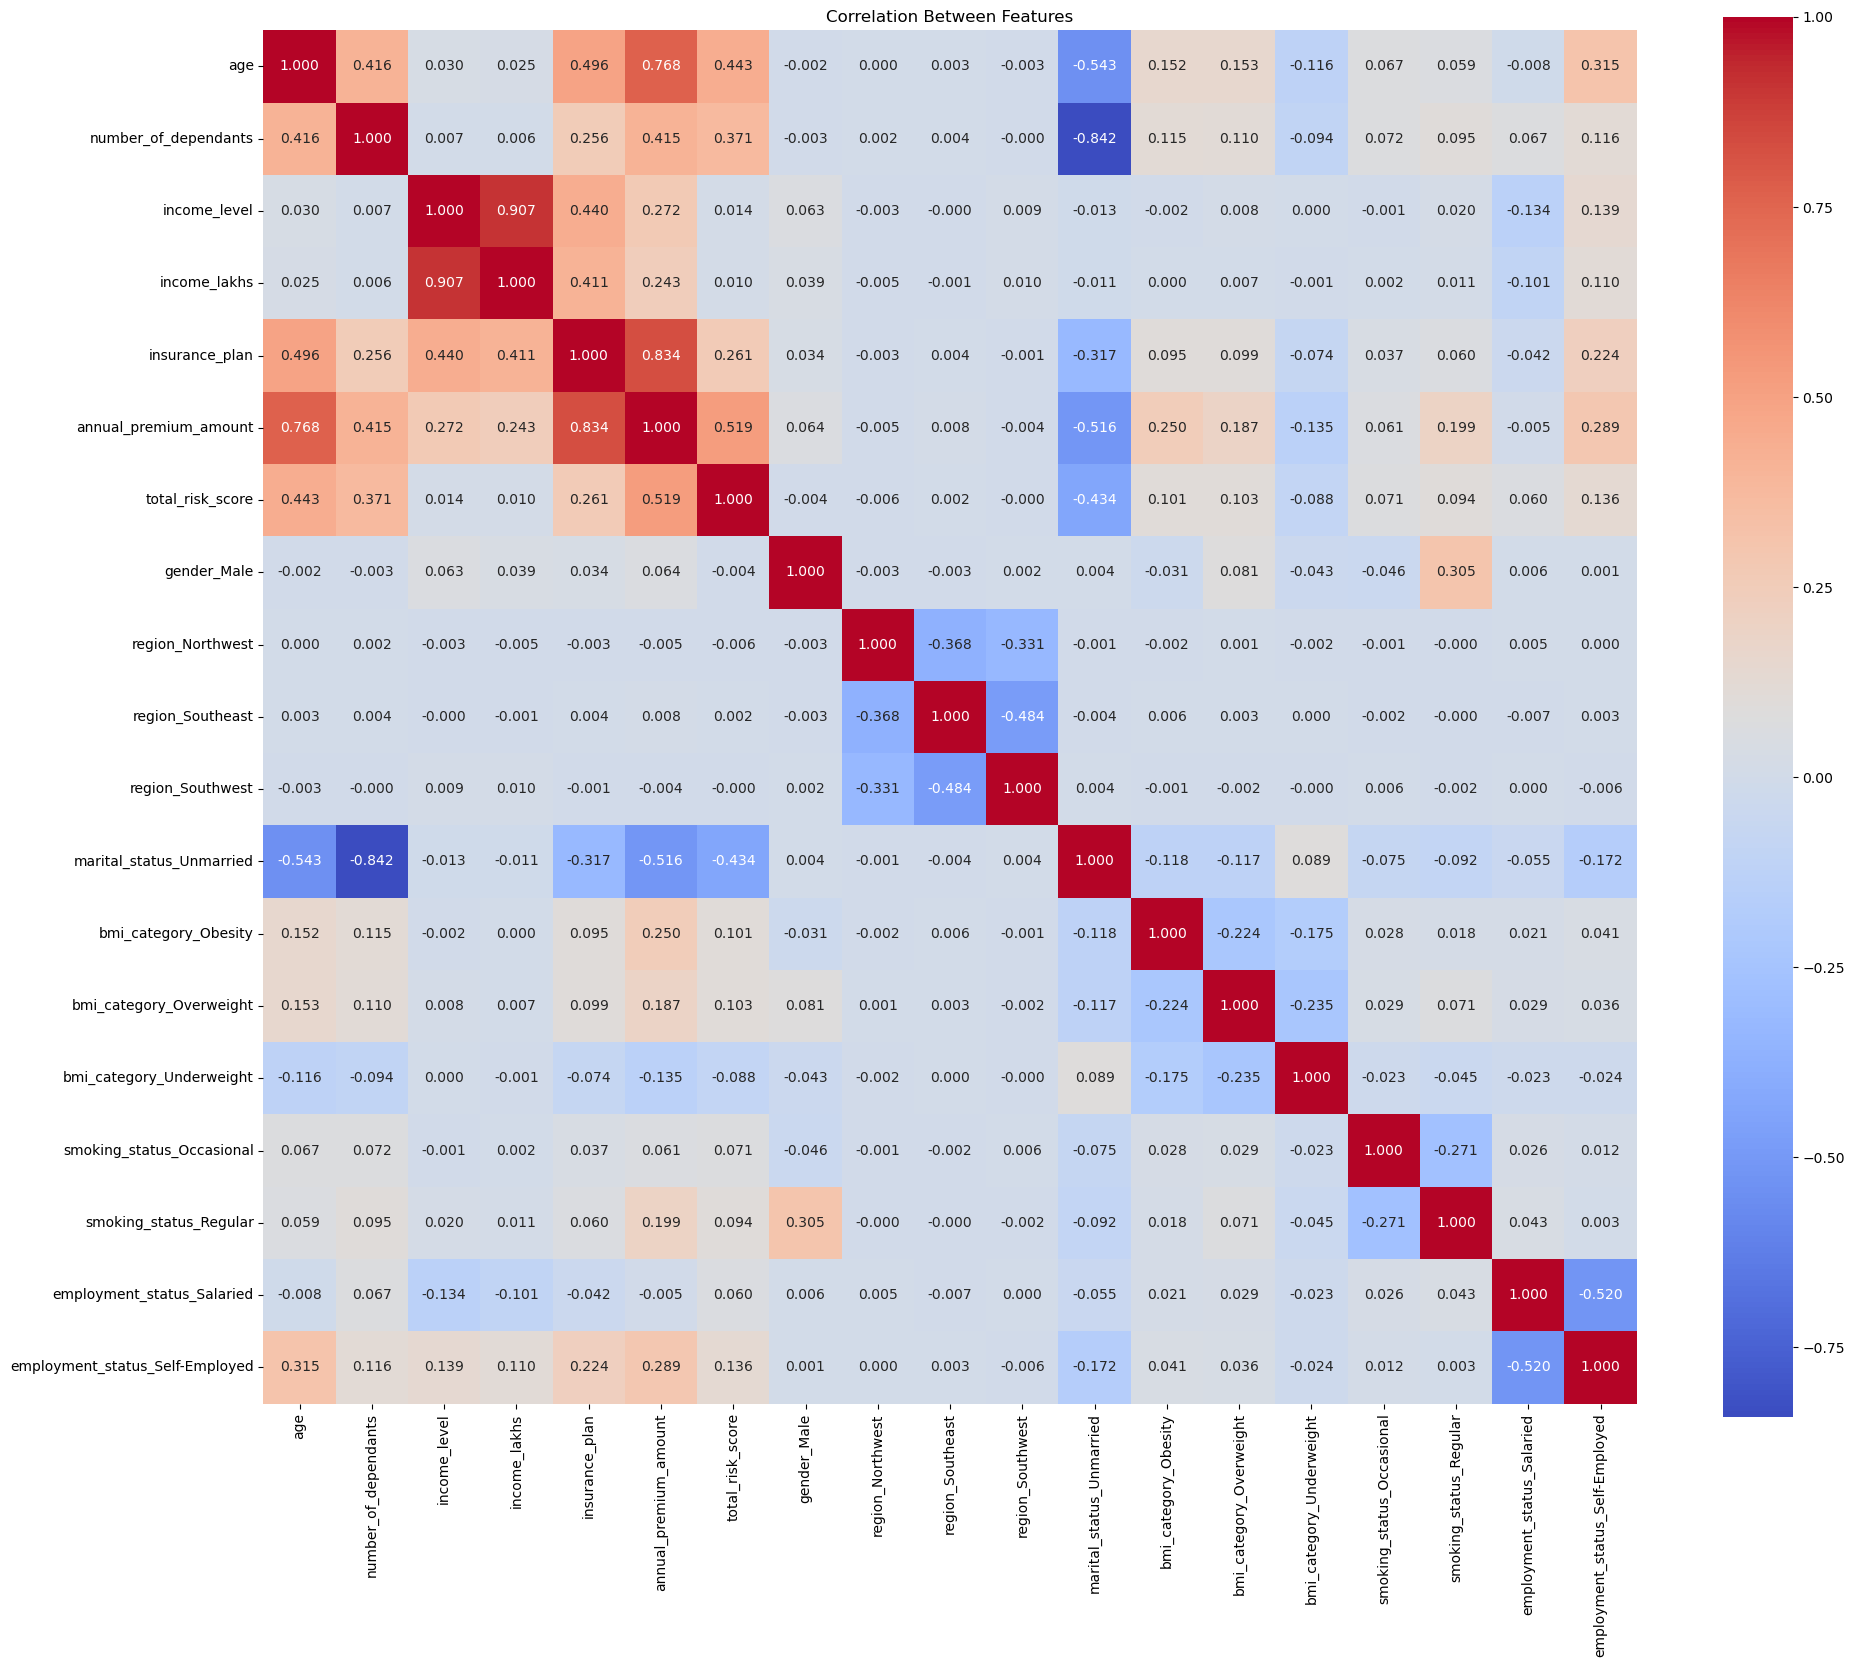

In [81]:
# Correlation Matrix displayed as a Heatmap

plt.figure(figsize=(20,20))
sns.heatmap(cr, annot=True, fmt='.3f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

In [82]:
# Display features that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount']

age                                0.767569
number_of_dependants               0.414691
income_level                       0.271811
income_lakhs                       0.243058
insurance_plan                     0.834148
annual_premium_amount              1.000000
total_risk_score                   0.519458
marital_status_Unmarried          -0.516350
bmi_category_Obesity               0.249847
employment_status_Self-Employed    0.289438
Name: annual_premium_amount, dtype: float64

In [83]:
# Extract the feature names (index labels) that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount'].index

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'employment_status_Self-Employed'],
      dtype='object')

**Observation**

Based on the correlation heatmap, a ***strong positive correlation*** with `annual_premium_amount` is observed for the features `age`, `number_of_dependants`, `income_level`, `income_lakhs`, `insurance_plan`, `total_risk_score`, `marital_status_Unmarried` and `bmi_category_Obesity` suggesting that these variables may significantly influence premium prediction.

Additionally, a ***strong negative correlation*** is shown by `marital_status_Unmarried`, indicating that being unmarried is generally associated with lower premium amounts.

#### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) will be checked to detect and address multicollinearity among the features.


In [84]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [85]:
# Calculate VIF for each feature and store the results in a new DataFrame

# Initialize a dictionary to store feature names and their corresponding VIF scores
vif_dict = {'features':[],'vif_score':[]}

# Exclude the target variable from VIF calculation
temp_df = df7.drop('annual_premium_amount',axis=1)

# Loop through each feature to compute VIF
for i,col in enumerate(temp_df.columns):
    # Calculate the Variance Inflation Factor for the current feature
    vif = variance_inflation_factor(temp_df,i)

    # Append the feature name and its VIF score to the dictionary
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

In [86]:
# Convert the VIF dictionary into a DataFrame for better readability and analysis
vif_df = pd.DataFrame(vif_dict)

# Sort features by their VIF scores in descending order to identify highly collinear features
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
2,income_level,12.450675
3,income_lakhs,11.183367
0,age,4.567634
1,number_of_dependants,4.534650
4,insurance_plan,3.584752
10,marital_status_Unmarried,3.411185
8,region_Southeast,2.922414
5,total_risk_score,2.687610
9,region_Southwest,2.670666
6,gender_Male,2.421496


After the Variance Inflation Factor (VIF) was calculated for all features, it was observed that both `income_level` and `income_lakhs` had VIF scores exceeding the commonly accepted threshold of 10, indicating the presence of high multicollinearity between them.

To address this issue and enhance model stability, the `income_level` feature was dropped, as it exhibited the higher VIF value of the two. This step was taken to reduce redundancy without significantly compromising the information contained in the dataset.

In [87]:
# Initialize a list to store highly collinear features to be removed later

high_vif_features  = []

In [88]:
# Identify the feature with the highest VIF score and add it to the removal list 'high_vif_features'

highest_vif_feature = vif_df['features'][vif_df['vif_score'].idxmax()]
high_vif_features.append(highest_vif_feature)
print(high_vif_features)

['income_level']


In [89]:
# Drop the most collinear feature from the temporary DataFrame

temp_df1 = temp_df.drop(['income_level'],axis=1).copy()
temp_df1

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49903,0.111111,0.0,0.343434,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
49904,0.537037,0.4,0.818182,1.0,0.357143,0,0,1,0,0,0,0,0,0,0,1,0
49905,0.055556,0.0,0.313131,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
49906,0.000000,0.4,0.191919,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0


The same process will be repeated until all VIF values are within the acceptable threshold.

In [90]:
# Recalculate VIF scores for the updated feature set

vif_dict = {'features':[],'vif_score':[]}

for i,col in enumerate(temp_df1.columns):
    vif = variance_inflation_factor(temp_df1,i)
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

# Create a DataFrame from the updated VIF scores
vif_df = pd.DataFrame(vif_dict)

# Sort VIF scores in descending order to identify next candidates for removal
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
0,age,4.545825
1,number_of_dependants,4.526598
3,insurance_plan,3.445682
9,marital_status_Unmarried,3.393718
7,region_Southeast,2.919775
4,total_risk_score,2.687326
8,region_Southwest,2.668314
2,income_lakhs,2.480563
5,gender_Male,2.409980
15,employment_status_Salaried,2.374628


All remaining features have acceptable VIF scores.

In [91]:
# Remove the previously identified high-VIF features from the original DataFrame.
final_df = df7.drop(high_vif_features,axis=1)

# Display the final cleaned dataset
final_df

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49903,0.111111,0.0,0.343434,0.0,9111,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
49904,0.537037,0.4,0.818182,1.0,27076,0.357143,0,0,1,0,0,0,0,0,0,0,1,0
49905,0.055556,0.0,0.313131,0.0,8564,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
49906,0.000000,0.4,0.191919,0.0,9490,0.000000,1,1,0,0,1,0,0,0,0,0,1,0


## Model Selection

The model selection process proceeded as follows:

1. Split the dataset into training and test sets.  
2. Trained different models on the training data.  
3. Used cross-validation to compare model performance.  
4. Tuned hyperparameters of the best model.  
5. Evaluated the final model’s performance on the test set. 

### Dataset Split

The dataset is divided as follows:

- Training set: 70%
- Test set: 30%

Split was done randomly with a fixed seed for reproducibility.

In [92]:
# Separate features and target variable

features = final_df.drop(['annual_premium_amount'],axis=1)
target = final_df['annual_premium_amount']

In [93]:
# Split the data into training and test sets

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=42)

In [94]:
# Display the shape of training and test sets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (34935, 17), y_train shape: (34935,)
X_test shape: (14973, 17), y_test shape: (14973,)


### Model Training

Various models will be tried and training will be performed, including:

* Linear Regression  
* Ridge Regression  
* Lasso Regression  
* Random Forest Regressor  
* XGBoost Regressor

#### Linear Regression

In [95]:
# Initialize and train the Linear Regression model
lr=LinearRegression()
lr.fit(X_train,y_train)

# Evaluate model performance
train_score = lr.score(X_train,y_train)
test_score = lr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9280957176093705 , Test Score : 0.9283765993531427 


In [96]:
# Predict on test data
y_pred = lr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 5056639.130347778 , RMSE : 2248.697207350909


In [97]:
# Feature Names and Its Coefficents

print('Features -> ',lr.feature_names_in_)
print('\n','**'*50)
print('Coef -> ',lr.coef_)

Features ->  ['age' 'number_of_dependants' 'income_lakhs' 'insurance_plan'
 'total_risk_score' 'gender_Male' 'region_Northwest' 'region_Southeast'
 'region_Southwest' 'marital_status_Unmarried' 'bmi_category_Obesity'
 'bmi_category_Overweight' 'bmi_category_Underweight'
 'smoking_status_Occasional' 'smoking_status_Regular'
 'employment_status_Salaried' 'employment_status_Self-Employed']

 ****************************************************************************************************
Coef ->  [11236.4082633   -536.61172956  -353.97067084 12515.43782972
  4846.88626348   121.53023031   -34.50219135    27.97504587
   -23.47372614  -821.78088646  3356.07750448  1613.1421694
   364.31350886   722.41051531  2261.97816483   149.57179545
   378.25130285]


In [98]:
# Creating a dataframe of features and coefficients

feat_coef = {
    'features' : lr.feature_names_in_,
    'coef' : lr.coef_
}

feat_coef_df = pd.DataFrame(feat_coef)
feat_coef_df.sort_values(by=['coef'],ascending=False)

,features,coef
3,insurance_plan,12515.437830
0,age,11236.408263
4,total_risk_score,4846.886263
10,bmi_category_Obesity,3356.077504
14,smoking_status_Regular,2261.978165
11,bmi_category_Overweight,1613.142169
13,smoking_status_Occasional,722.410515
16,employment_status_Self-Employed,378.251303
12,bmi_category_Underweight,364.313509
15,employment_status_Salaried,149.571795


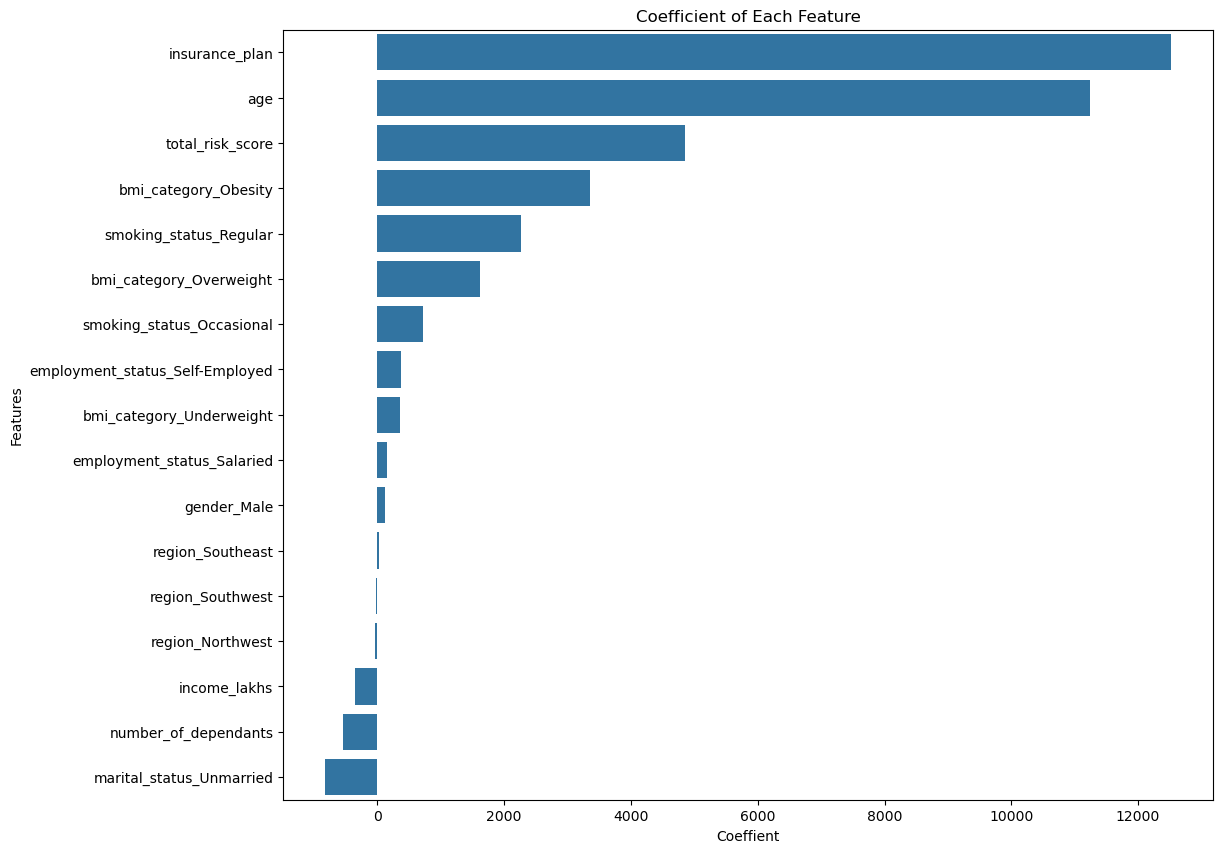

In [99]:
# Plotting the features and its coefficients

plt.figure(figsize=(12,10))
sns.barplot(data=feat_coef_df.sort_values(by=['coef'],ascending=False),x = 'coef',y = 'features' )
plt.title('Coefficient of Each Feature')
plt.xlabel('Coeffient')
plt.ylabel('Features')
plt.show()

#### Lasso Regression

In [100]:
# Initialize and train the Lasso Regression model
ls = Lasso()
ls.fit(X_train,y_train)

# Evaluate model performance
train_score = ls.score(X_train,y_train)
test_score = ls.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9280927085624446 , Test Score : 0.9283637752728616 


In [101]:
# Predict on test data
y_pred = ls.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 5057544.515257937 , RMSE : 2248.8985115513633


#### Ridge Regression

In [102]:
# Initialize and train the Ridge Regression model
rg = Ridge()
rg.fit(X_train,y_train)

# Evaluate model performance
train_score = rg.score(X_train,y_train)
test_score = rg.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9280956798900618 , Test Score : 0.9283764905001947 


In [103]:
# Predict on test data
y_pred = rg.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 5056646.815407011 , RMSE : 2248.698916130617


**Observation**

Neither Lasso nor Ridge regression showed significant improvement over Linear Regression.

#### Random Forest Regressor

In [104]:
# Initialize and train the Random Forest Regression model
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

# Evaluate model performance
train_score = rfr.score(X_train,y_train)
test_score = rfr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9965624084011903 , Test Score : 0.9789213192357614 


In [105]:
# Predict on test data
y_pred = rfr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 1488162.821171972 , RMSE : 1219.902791689556


Based on the R² score, it can be seen that this model fits the data well. The XGBoost model will be tried next.

#### XGboost Regressor

In [106]:
# Initialize and train the XGboost model
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

# Evaluate model performance
train_score = xgb.score(X_train,y_train)
test_score = xgb.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9861041903495789 , Test Score : 0.9807721972465515 


In [107]:
# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 1357488.75 , RMSE : 1165.1131591796875


**Model Performance Comparison: XGBoost vs. Random Forest**

Both XGBoost and Random Forest models are observed to perform well on the dataset. However, the following points are noted:

- A lower training score and a higher test score are yielded by the XGBoost model compared to Random Forest.
- This suggests that the XGBoost model generalizes better and is less prone to overfitting.
- To validate this observation, cross-validation will be used to evaluate both models more robustly using `cross_validate`.

Cross-validation will be performed on both Random Forest and XGBoost models, with the run time also being recorded.  
The `cross_validate` function is used instead of `cross_val_score` to obtain both training and testing scores.

### Cross Validation - RF vs XGboost

Stratified K-Fold will not be performed since this is a regression task; therefore, K-Fold cross-validation is considered sufficient.

In [108]:
# Set up 5-fold cross-validation

kf = KFold(n_splits = 5,shuffle=True,random_state=42)

In [ ]:
# Perform cross-validation for Random Forest Regressor

start_time = time()
cv_rfr = cross_validate(rfr,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_rfr = end_time - start_time
print(f'Total Time Taken : {round(total_time_rfr,2)} seconds')

In [ ]:
# Display training scores
print("Training scores (R²):", cv_rfr['train_score'])

# Display test scores
print("Validation scores (R²):", cv_rfr['test_score'])

In [ ]:
# Perform cross-validation for XGboost Regressor

start_time = time()
cv_xgb = cross_validate(xgb,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_xgb = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb,2)} seconds')

In [ ]:
# Display training scores
print("Training scores (R²):", cv_xgb['train_score'])

# Display test scores
print("Validation scores (R²):", cv_xgb['test_score'])

In [ ]:
cv_df = pd.DataFrame(
    {
        'model' : ['Random Forest','XGboost'],
        'execution_time (seconds)' : [total_time_rfr,total_time_xgb],
        'average_train_score' : [np.mean(cv_rfr['train_score']),np.mean(cv_xgb['train_score'])],
        'average_test_score' : [np.mean(cv_rfr['test_score']),np.mean(cv_xgb['test_score'])]
    }
)

cv_df

**Cross-Validation Summary: XGBoost vs. Random Forest**

The cross-validation results confirm that XGBoost is consistently observed to generalize better than the Random Forest model:

- *Lower training scores* and *higher test scores* were achieved by XGBoost, indicating *better generalization* and *reduced overfitting*.
- In terms of performance, XGBoost was approximately ***83 times faster*** than Random Forest during cross-validation.

Given its superior predictive performance and computational efficiency, **XGBoost will be selected as the final model**.


### Hyperparameter Tuning

The model will be fine-tuned using `RandomizedSearchCV`, as it is computationally less expensive than `GridSearchCV`.

Hyperparameter combinations are randomly sampled, making this approach generally faster for large search spaces.

#### RandomizedSearchCV

In [ ]:
xgb = XGBRegressor(booster= 'gbtree')

In [ ]:
param_grid = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1,0.15,0.2],
    'max_depth' : [7,8,9],
    'gamma' : [1,2,3]
    
}

A total of 81 hyperparameter combinations are available. A smaller subset of combinations will be selected to reduce computational cost.

In [ ]:
# Adjust based on resources

iter_to_perform = 10

In [ ]:
# Initialize RandomizedSearchCV

rscv = RandomizedSearchCV(xgb,param_grid,cv=kf,n_iter=iter_to_perform,random_state=42)

In [ ]:
# Executing RandomizedSearchCV and Timing the search

start_time = time()
rscv.fit(features,target)
end_time = time()
total_time_xgb_hyp = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb_hyp,2)} seconds')

#### Best Model

In [ ]:
# Displaying the results of RandomizedSearchCV execution

pd.DataFrame(rscv.cv_results_)

In [ ]:
# Best score we get from the Tuning

rscv.best_score_

In [ ]:
# Parameters that gave the best score

rscv.best_params_

In [ ]:
# Model that resulted the best score

best_model = rscv.best_estimator_
best_model

### Performance of the 'Best Model'

The best model’s performance was evaluated on the test set to assess its real-world effectiveness.

#### Scores

In [ ]:
# Evaluate Best model's performance
train_score = best_model.score(X_train,y_train)
test_score = best_model.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

In [ ]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics of the best model
print(f'MSE : {mse} , RMSE : {rmse}')

#### Features and their Importance

The contribution of each feature to the model's predictions was analyzed.

In [ ]:
# Retrieve feature names used during model training (available after fitting)

best_model.feature_names_in_

In [ ]:
# Feature importance scores from the fitted model

best_model.feature_importances_

In [ ]:
# Create a DataFrame of features and their corresponding importance scores
feat_coef_df = pd.DataFrame(
    {
        'features' : best_model.feature_names_in_,
        'importance' : best_model.feature_importances_
    }
)

# Sort the features by importance in descending order
feat_coef_df = feat_coef_df.sort_values(by=['importance'],ascending=False)
feat_coef_df

In [ ]:
# Plot feature importances using a horizontal bar chart
sns.barplot(data = feat_coef_df, x='importance',y='features')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Trained Model")
plt.show()

## Error Anlysis

The prediction errors (residuals) will be analyzed to evaluate the model’s performance.

**Objective:**  
Ensure that 95% of incorrect predictions deviate by ≤10% from the actual values.

**Approach:**  
- Residuals will be calculated as: residual = actual − predicted  
- Percentage error relative to actual values will be computed.  
- The proportion of errors falling within the 10% threshold will be checked.  
- Any consistent error patterns across customer segments will be identified.

In [ ]:
# Predict on test data

y_pred = best_model.predict(X_test)

In [ ]:
# Check the shape of predictions and actual test labels to ensure alignment

print("Predicted labels shape:", y_pred.shape)
print("Actual labels shape:", y_test.shape)

### Residuals 

The difference between the predicted values and the actual values will be determined.

In [ ]:
# Calculate residuals (difference between predicted and actual values)
residuals = y_pred - y_test

# Display the residuals
residuals

In [ ]:
# Calculate the residual percentage
# What it shows? - How much the predicted value is deviated from the actual value
# 2.68 -> Predicted Value is 2.68% higher than the actual value

residuals_pct = ((y_pred - y_test) / y_test)*100
residuals_pct

Everything will be put into a dataframe for better understanding.

In [ ]:
# Create a dictionary to store actual, predicted, residuals, and residual percentages
residual_dict = {
    'actual' : y_test,
    'predicted' : y_pred,
    'residual' : residuals,
    'residual_pct' : residuals_pct
}

# Convert the dictionary into a DataFrame for easier analysis
residual_df = pd.DataFrame(residual_dict)

# Display the DataFrame
residual_df

In [ ]:
# Sort the residual_df by residual_pct in descending order to see the largest errors first

residual_df.sort_values(by=['residual_pct'],ascending=False)

In [ ]:
# Plot the distribution of residual percentages with a Kernel Density Estimate (KDE) overlay
sns.histplot(data = residual_df, x = 'residual_pct',kde=True )
plt.title('Distribution of Residual Deviations')
plt.xlabel('Residual Percentage (%)')
plt.ylabel('Frequency')
plt.show()

As observed above, some predicted values are 60%, 70%, 80%, or even 100% higher than the actual values, which is undesirable. The instances with such errors will be examined further.

### Analysing Extreme Residuals

As stated in the Statement of Work (SOW):

- The goal is to ensure that 95% of incorrect predictions deviate by no more than 10% from the actual values.

This implies that even when predictions are incorrect, **95%** of them should exhibit **less than 10% deviation** - either above or below the actual values.

In other words, only **5%** of incorrect predictions are permitted to deviate by **more than 10%** from the actual values.

Based on this requirement, the deviation threshold has been set at **10%**.

In [ ]:
# Acceptable percentage deviation allowed between actual and expected values

deviation_pct = 10

In [ ]:
# Filter rows where the absolute residual percentage exceeds the deviation_pct (10%)
extreme_residual = residual_df[abs(residual_df['residual_pct']) > deviation_pct]

# Display a random sample of 2 such extreme residuals for inspection
extreme_residual.sample(2)

In [ ]:
# Get the number of rows and columns in the filtered DataFrame (extreme residuals)
extreme_residual.shape

In [ ]:
# Get the number of rows and columns in the original residual DataFrame
residual_df.shape

In [ ]:
# Calculate the percentage of residuals that exceed the deviation_pct
extreme_residual_percentage = (extreme_residual.shape[0] / residual_df.shape[0])*100

# Display the calculated percentage
extreme_residual_percentage

It has been observed that approximately **25%** of the predicted values deviate by **more than 10%** from the actual values - **400% more** than the allowed **5%** threshold.

Where this issue originates must be determined.  
A deeper investigation is required to understand how such large residuals are produced.


In [ ]:
# Retrieve the indexes of rows with residuals exceeding the defined threshold

extreme_residual.index

In [ ]:
len(extreme_residual.index)

In [ ]:
# Extract the original rows from X_test where the model had large prediction errors
extreme_residual_df = X_test.loc[extreme_residual.index]

# Display the extracted rows with extreme residuals
extreme_residual_df

To gain insights about the potential features that causes the large deviations, the distribution of each feature in `X_test` and `extreme_residual_df` will be plotted.

By comparing the distributions across both datasets, it can be observed how each feature behaves and whether any specific feature contributes significantly to the high residuals.

In [ ]:
# Plot feature distributions to compare the X_test set vs rows with extreme residuals
for feature in X_test.columns:
    plt.figure(figsize=(8, 4))
    
    # X_test data distribution
    sns.histplot(data=X_test, x=feature, kde=True, color='skyblue', label='All Test Data', alpha=0.5)
    
    # Extreme residuals distribution
    sns.histplot(data=extreme_residual_df, x=feature, kde=True, color='salmon', label='Extreme Residuals', alpha=0.6)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

It can be observed that the distribution of the `age` feature is not aligned with the original distribution.

This indicates that most of the errors are clustered around the `age` feature.

### Features Driving Extreme Residuals

We have identified that the feature **`age`** is associated with the extreme residuals.

Next, it is important to investigate **which specific values** of `age` feature correspond to these large residuals to better understand where the deviations occur.


In [ ]:
# Plot histogram of 'age' feature for data with extreme residuals
plt.hist(extreme_residual_df['age'], color='salmon', alpha=0.7)
plt.title('Distribution of Age (with Extreme Errors)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The extreme errors are observed at these specific `age` values, which are currently scaled.

To interpret them meaningfully, the scaled `age` values need to be converted back to their original scale by applying an inverse transformation.

In [ ]:
# Retrieve feature names used to fit the MinMaxScaler (mms) earlier in the pipeline

mms.feature_names_in_

In [ ]:
# List of feature columns in the DataFrame containing extreme residual samples

extreme_residual_df.columns

The scaler object was originally trained using 6 columns:

- `age`  
- `number_of_dependants`  
- `income_level`  
- `income_lakhs`  
- `insurance_plan`  
- `total_risk_score`

However, the `extreme_residual_df` contains only 5 columns:

- `age`  
- `number_of_dependants`  
- `income_lakhs`  
- `insurance_plan`  
- `total_risk_score`

The column `income_level` is missing from this dataframe.


In [ ]:
# Add a new dummy column 'income_level' initialized to 0 as a placeholder in extreme_residual_df
extreme_residual_df['income_level'] = 0

# Display the first few rows to verify the new column addition
extreme_residual_df.head()

In [ ]:
# List of columns that were previously selected for scaling

cols_to_scale

In [ ]:
# Reverse the scaling transformation on the selected columns of extreme_residual_df
# to get the original (descaled) feature values

descaled_extreme_residual_df = pd.DataFrame(data=mms.inverse_transform(extreme_residual_df[cols_to_scale]),
                          columns=cols_to_scale)

# Display the descaled DataFrame
descaled_extreme_residual_df

In [ ]:
# Plot histogram of the 'age' feature from the descaled data with extreme residuals

plt.hist(descaled_extreme_residual_df['age'], color='salmon', alpha=0.7)
plt.title('Distribution of Age (with Extreme Errors)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Final Verdict

As observed, the age group between 18 and 25 is responsible for the most extreme errors.  
Therefore, the model will be segmented into two categories:

- **Young age** (≤ 25 years)  
- **Rest** (> 25 years)